In [1]:
import anndata as ad

# PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type__processed.h5ad'
PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_donor_id__label_cell_type__processed.h5ad'

adata_predict = ad.read_h5ad(PATH)
nbins = adata_predict.uns['nbins']
results = adata_predict.uns['results']

In [2]:
adata_predict

AnnData object with n_obs × n_vars = 97 × 5792
    obs: 'dataset_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'label', 'sample', 'n_genes', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'column_1', 'column_2', 'column_3', 'column_4', 'external_gene_name', 'gene_biotype', 'train', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_label', 'hvg', 'log1p', 'nbins', 'obs_embedding_pca', 'preprocessing', 'rank_genes_groups', 'results', 'var_embedding_pca'
    obsm: 'bin_edges', 'embedding'
    varm: 'embedding', 'embedding_pca'
    layers: 'binned', 'confidence', 'counts', 'log1p', 'normalized_counts', 'predicted', 'target'

In [3]:
print(
    f"""
    mean spearman across genes {results['spearman_obs_mean']:.3f}
    mean spearman across cells {results['spearman_var_mean']:.3f}
    """
)  


    mean spearman across genes 0.599
    mean spearman across cells 0.259
    


In [4]:
# import numpy as np
# cm = results['confusion_matrix']
# print(cm.sum(axis=1))
# X = cm / cm.sum(axis=1)[:, np.newaxis]

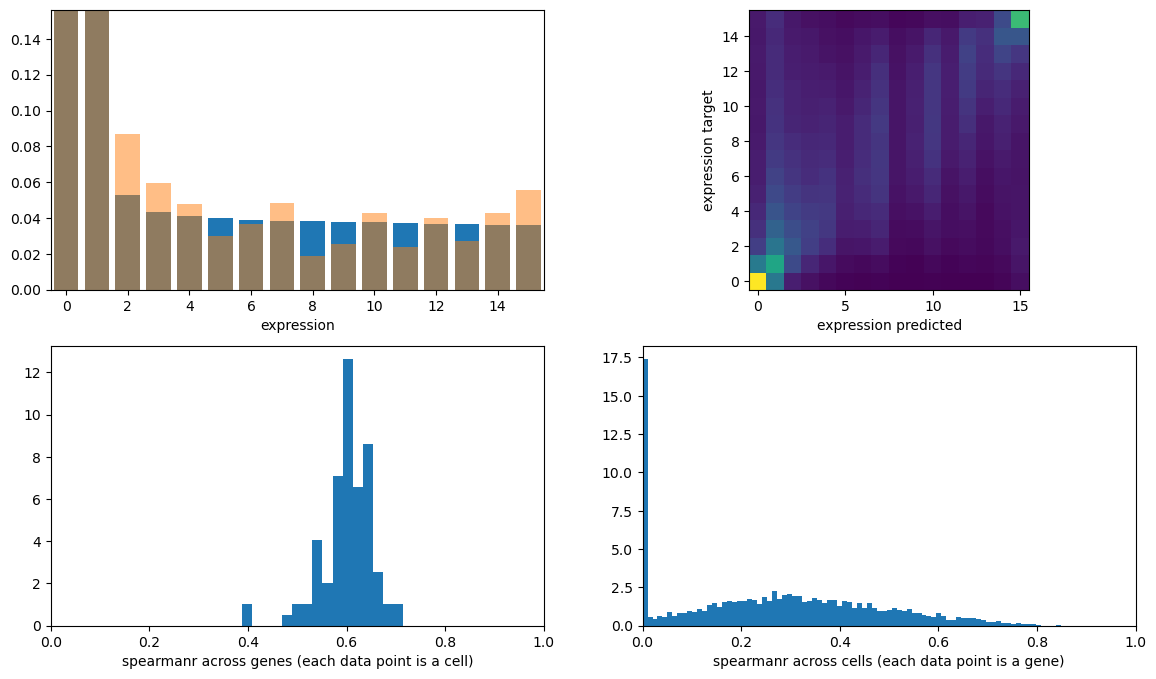

In [5]:
from rosa.utils import plot_expression_and_correlation, plot_marker_gene_heatmap
  
plot_expression_and_correlation(results)

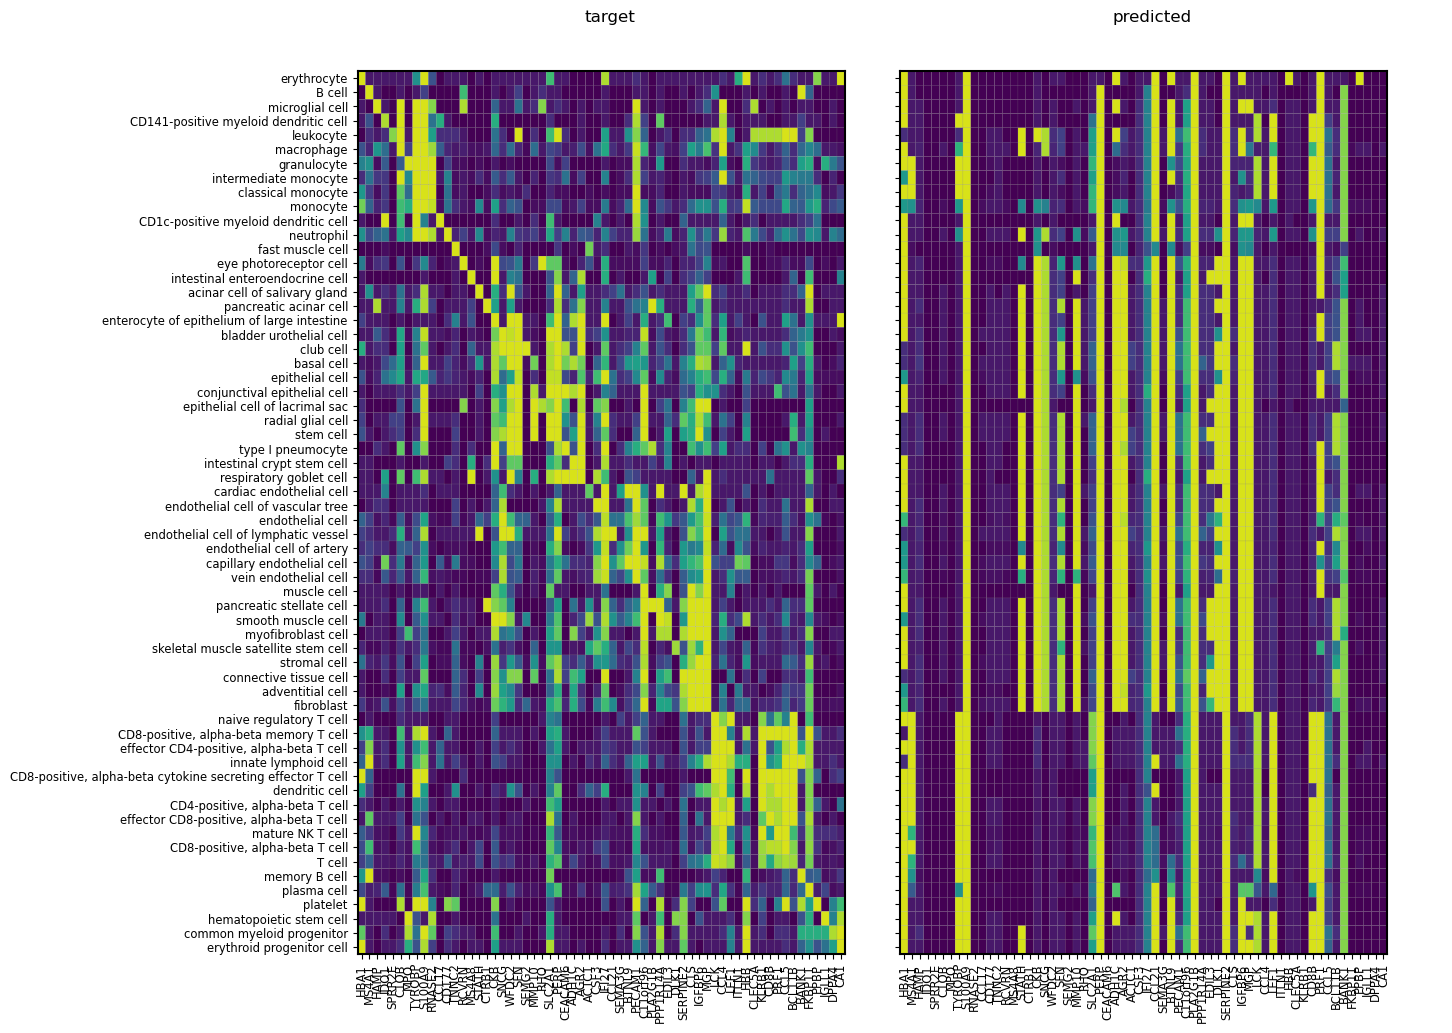

In [6]:
import scanpy as sc

marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']
sc.tl.dendrogram(adata_predict, groupby="label", use_rep="X")
plot_marker_gene_heatmap(adata_predict, marker_genes_dict)

## Extras

In [ ]:
# import seaborn as sns
# from scipy.cluster.hierarchy import linkage
# import sys


# sys.setrecursionlimit(100000)

In [ ]:
# row_linkage = linkage(adata_predict.layers['measured']) # D being the measurement
# col_linkage = linkage(adata_predict.layers['measured'].T) # D being the measurement
# sns.clustermap(adata_predict.layers['measured'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['predicted'], row_linkage=row_linkage, col_linkage=col_linkage)

In [ ]:
# sns.clustermap(adata_predict.layers['confidence'], row_linkage=row_linkage, col_linkage=col_linkage)

## Value histograms

In [ ]:
import numpy as np

In [ ]:
values, counts = np.unique(adata_predict.layers['measured'], return_counts=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(values, counts)

In [ ]:
values

In [ ]:
counts

In [ ]:
import torch

In [ ]:
from tqdm import tqdm

In [ ]:
full_binned = []
full_boundaries = []

n_bins = 16
for i, row in tqdm(enumerate(adata_predict.X)):
    tensor = torch.Tensor(row.toarray())

    boundaries = [torch.tensor(0.0)]
    for q in range(n_bins - 1):
        data_remaining = tensor[tensor>boundaries[-1]]
        n_data_remaining = len(data_remaining)
        if n_data_remaining == 0:
            next_val = boundaries[-1]
        else:
            n_bins_remaining = n_bins - q - 1
            next_quantile = 1 / n_bins_remaining
            next_val = max(boundaries[-1] + 1, torch.quantile(data_remaining, next_quantile))
        boundaries.append(next_val)
    boundaries = torch.stack(boundaries, dim=0)

    full_binned.append(torch.bucketize(tensor, boundaries))
    full_boundaries.append(boundaries)
full_binned = torch.cat(full_binned, dim=0)
full_boundaries = torch.stack(full_boundaries)

In [ ]:
full_boundaries[12]

In [ ]:
full_boundaries[:, -1]

In [ ]:
values, counts = torch.unique(full_binned, return_counts=True)

In [ ]:
print(values)
print(counts)

In [ ]:
plt.plot(values, counts)

In [ ]:
values, counts = torch.unique(expression, return_counts=True)
nbins = self.transform[-1].n_bins
bin_counts = torch.zeros(nbins, dtype=torch.long)
bin_counts[values] = counts
mask_indices = torch.multinomial(1 / bin_counts[expression], int(self.mask * len(expression)))
mask = torch.zeros(expression.shape, dtype=torch.bool)
mask[mask_indices] = True

mask_type = torch.rand(1)
if mask_type < self.pass_through:
    pass
elif mask_type < self.corrupt:
    count_inds = torch.multinomial(counts, len(mask_indices))
    expression[mask] = values[count_inds]

In [ ]:
if torch.rand(1) < 0.3:
    print('a')

## Scanpy plots

In [ ]:
import scanpy as sc

In [ ]:
marker_genes_dict = adata_predict.obs.set_index('label').to_dict()['marker_feature_name']

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer=None,
    vmin=0,
    vmax=1e2,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='confidence',
    vmin=0,
    vmax=1,
    show=False,
    title='confidence',
    dendrogram=True,
)

In [ ]:
sc.pl.dotplot(
    adata_predict,
    marker_genes_dict,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
marker_genes_dict_2 = {}

for key, value in list(marker_genes_dict.items())[:20]:
    marker_genes_dict_2[key] = value

In [ ]:
sc.pl.matrixplot(
    adata_predict,
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer='measured',
    vmin=0,
    vmax=15,
    show=False,
    title='measured',
    dendrogram=True,
)

In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="measured",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes = sc.pl.heatmap(
    adata_predict[:1000],
    marker_genes_dict_2,
    groupby="label",
    gene_symbols="feature_name",
    layer="predicted",
    vmin=0,
    vmax=15,
    show=False,
    dendrogram=False,
)
for l in axes['heatmap_ax'].lines:
    l.remove()


In [ ]:
axes['heatmap_ax'].clear()

In [ ]:
for a in axes['heatmap_ax'].lines:
    print(a)

In [ ]:
axes

In [ ]:
del axes['gene_groups_ax']

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)